# Getting started with CUDA

### Setup

In [8]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [9]:
!nvidia-smi

Sat Feb 17 15:56:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   23C    P8              10W / 280W |     47MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
# # uncomment this cell to download the image we are going to use in the rest of the notebook
# !wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg -O ../../imgs/puppy.jpg

--2024-02-17 15:59:50--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394251 (385K) [image/jpeg]
Saving to: ‘../../imgs/puppy.jpg’

../../imgs/puppy.jp 100%[===================>] 385.01K   530KB/s    in 0.7s    

2024-02-17 15:59:51 (530 KB/s) - ‘../../imgs/puppy.jpg’ saved [394251/394251]



In [23]:
img = io.read_image("../../imgs/puppy.jpg")
print(img.shape)
img[:2, :3, :4]

torch.Size([3, 1066, 1600])


tensor([[[117, 119, 117, 113],
         [119, 129, 129, 113],
         [130, 126, 122, 115]],

        [[ 83,  85,  85,  80],
         [ 85,  97,  97,  82],
         [ 98,  93,  89,  83]]], dtype=torch.uint8)

In [24]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if len(x.shape)==3: 
        x = x.permute(1,2,0)  #CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [25]:
img2 = tvf.resize(img, 150, antialias=True)
ch, h, w = img2.shape
ch, h, w, h*w

(3, 150, 225, 33750)

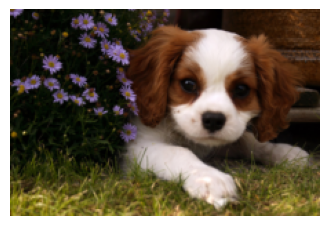

In [26]:
show_img(img2)